# NBA Predict

## Dataset and motivation

This dataset is collect from [basketball reference](https://www.basketball-reference.com), which has almost all data of NBA. We try to collect NBA data to analyse every team and player's game performance.

## Actual task definition/Research Question 

We are trying to analyze the recent 5 years NBA games results to predict win or lose of every game, and to analyze MVP votings recent years to predict NBA normal season most valuable player.

input: tables from [basketball reference](https://www.basketball-reference.com).

output: predict results.

## Literature review

We reference some data features from [MVP prediction model](https://towardsdatascience.com/nba-mvp-predictor-c700e50e0917). 

In our work, we get mean of 10 recent game results before the game we analyse as the base data to predict the result of this game. And we get recent years MVP votings results and player performances of entire normal season to predict their voting rankings.

In [1]:
use_intermediate_results = True

In [2]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
%matplotlib inline

### Team List and their Abbreviations
We get all NBA/ABA temas' names and their abbreviations.

In [3]:
url = 'https://www.basketball-reference.com/teams/'
html = requests.get(url).content
df_list = pd.read_html(html)
tames = df_list[0]

#### Glossary:  
    Lg -- League  From -- First year  To -- Last year  G -- Games  W -- Wins  L -- Losses  
    W/L% -- Win-Loss Percentage  Plyfs -- Years team made the playoffs  
    Div -- Years team finished first (or tied for first) in the division  
    Conf -- Years team won the conference championship  Champ -- Years team won the league championship

In [4]:
tames

,Franchise,Lg,From,To,Yrs,G,W,L,W/L%,Plyfs,Div,Conf,Champ
0,Atlanta Hawks,NBA,1950,2019,70,5552,2746,2806,0.495,46,11,0,1
1,Atlanta Hawks,NBA,1969,2019,51,4134,2048,2086,0.495,33,5,0,0
2,St. Louis Hawks,NBA,1956,1968,13,1005,553,452,0.550,12,6,0,1
3,Milwaukee Hawks,NBA,1952,1955,4,281,91,190,0.324,0,0,0,0
4,Tri-Cities Blackhawks,NBA,1950,1951,2,132,54,78,0.409,1,0,0,0
5,Boston Celtics,NBA/BAA,1947,2019,73,5724,3378,2346,0.590,56,31,9,17
6,Brooklyn Nets,NBA/ABA,1968,2019,52,4222,1824,2398,0.432,27,5,2,2
7,Brooklyn Nets,NBA,2013,2019,7,574,242,332,0.422,4,0,0,0
8,New Jersey Nets,NBA,1978,2012,35,2822,1186,1636,0.420,16,4,2,0
9,New York Nets,NBA,1977,1977,1,82,22,60,0.268,0,0,0,0


In [5]:
team_l = list(tames[tames.To==2019].Franchise.unique())

Generate 30 NBA teams' names and their abbreviations nowadays.

In [6]:
teams_d = {}
for team in team_l:
    name = team.split(' ')
    if len(name) == 2:
        abb = name[0][:3].upper()
    else:
        abb = ''
        for word in name:
            abb += word[0].upper()
    team_name = '_'.join(name)
    teams_d[team_name] = abb

In [7]:
teams_d['Oklahoma_City_Thunder'] = 'OKC'
teams_d['Brooklyn_Nets'] = 'NJN'
teams_d['Charlotte_Hornets'] = 'CHO'
teams_d['Brooklyn_Nets'] = 'BRK'
teams_d['Portland_Trail_Blazers'] = 'POR'
teams_d

{'Atlanta_Hawks': 'ATL',
 'Boston_Celtics': 'BOS',
 'Brooklyn_Nets': 'BRK',
 'Charlotte_Hornets': 'CHO',
 'Chicago_Bulls': 'CHI',
 'Cleveland_Cavaliers': 'CLE',
 'Dallas_Mavericks': 'DAL',
 'Denver_Nuggets': 'DEN',
 'Detroit_Pistons': 'DET',
 'Golden_State_Warriors': 'GSW',
 'Houston_Rockets': 'HOU',
 'Indiana_Pacers': 'IND',
 'Los_Angeles_Clippers': 'LAC',
 'Los_Angeles_Lakers': 'LAL',
 'Memphis_Grizzlies': 'MEM',
 'Miami_Heat': 'MIA',
 'Milwaukee_Bucks': 'MIL',
 'Minnesota_Timberwolves': 'MIN',
 'New_Orleans_Pelicans': 'NOP',
 'New_York_Knicks': 'NYK',
 'Oklahoma_City_Thunder': 'OKC',
 'Orlando_Magic': 'ORL',
 'Philadelphia_76ers': 'PHI',
 'Phoenix_Suns': 'PHO',
 'Portland_Trail_Blazers': 'POR',
 'Sacramento_Kings': 'SAC',
 'San_Antonio_Spurs': 'SAS',
 'Toronto_Raptors': 'TOR',
 'Utah_Jazz': 'UTA',
 'Washington_Wizards': 'WAS'}

### Team Schedules and Results
We can get a team's whole shchedules and game results in a normal season.

In [8]:
url = 'https://www.basketball-reference.com/teams/LAL/2019_games.html'
html = requests.get(url).content
df_list = pd.read_html(html)
lakers = df_list[0]

Drop some rows with duplicated column names.

In [10]:
lakers[lakers.G=='G'].index

Int64Index([20, 41, 62, 83], dtype='int64')

In [11]:
lakers.drop(lakers[lakers.G=='G'].index, inplace=True )

In [12]:
lakers.reset_index(drop=True, inplace=True)

#### Glossary:
    G -- Games
    Start (ET) -- Time zone = ET
    Tm -- Points
    Opp -- Opponent Points
    W -- Wins
    L -- Losses

In [13]:
lakers.shape

(82, 15)

In [14]:
lakers.head(10)

,G,Date,Start (ET),Unnamed: 3,Unnamed: 4,Unnamed: 5,Opponent,Unnamed: 7,Unnamed: 8,Tm,Opp,W,L,Streak,Notes
0,1,"Thu, Oct 18, 2018",10:30p,NaN,Box Score,@,Portland Trail Blazers,L,NaN,119,128,0,1,L 1,NaN
1,2,"Sat, Oct 20, 2018",10:30p,NaN,Box Score,NaN,Houston Rockets,L,NaN,115,124,0,2,L 2,NaN
2,3,"Mon, Oct 22, 2018",10:30p,NaN,Box Score,NaN,San Antonio Spurs,L,OT,142,143,0,3,L 3,NaN
3,4,"Wed, Oct 24, 2018",10:00p,NaN,Box Score,@,Phoenix Suns,W,NaN,131,113,1,3,W 1,NaN
4,5,"Thu, Oct 25, 2018",10:30p,NaN,Box Score,NaN,Denver Nuggets,W,NaN,121,114,2,3,W 2,NaN
5,6,"Sat, Oct 27, 2018",8:30p,NaN,Box Score,@,San Antonio Spurs,L,NaN,106,110,2,4,L 1,NaN
6,7,"Mon, Oct 29, 2018",8:00p,NaN,Box Score,@,Minnesota Timberwolves,L,NaN,120,124,2,5,L 2,NaN
7,8,"Wed, Oct 31, 2018",10:30p,NaN,Box Score,NaN,Dallas Mavericks,W,NaN,114,113,3,5,W 1,NaN
8,9,"Sat, Nov 3, 2018",10:00p,NaN,Box Score,@,Portland Trail Blazers,W,NaN,114,110,4,5,W 2,NaN
9,10,"Sun, Nov 4, 2018",9:30p,NaN,Box Score,NaN,Toronto Raptors,L,NaN,107,121,4,6,L 1,NaN


From table above we can see there are some coolumns with missing names or values, we will deal with it later.

We generate a dictionary with 30 teams' schedules from Season 2015 to Season 2018, and drop some colunms only have nan values, rename coolumns, and change some columns' type from string to numeric.


In [16]:
years = [2019,2018,2017,2016,2015]
seasons = {}
to_num_list = ['W', 'L']
for year in years:
    seasons[year]={}
    for name, add in teams_d.items():
        url = 'https://www.basketball-reference.com/teams/' + add + '/' + str(year) + '_games.html'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df = df_list[0]
        df.drop(df[df.G=='G'].index, inplace=True)
        df.reset_index(drop=True, inplace=True)
        df['Opponent'] = df.Opponent.map(lambda x: '_'.join(x.split(' ')))
        df['Date'] = df.Date.map(lambda x: ''.join(str(pd.to_datetime(x)).split(' ')[0].split('-')))
        df.drop(df.columns[[3, 4]], axis=1, inplace=True)
        df.rename(columns = {'Unnamed: 5':'Guest','Unnamed: 7':'Win_or_Lose','Unnamed: 8':'OverTime'}, inplace=True)
        df[to_num_list] = df[to_num_list].apply(pd.to_numeric)
        seasons[year][name] = df


In [18]:
seasons[2015]['Los_Angeles_Lakers'].head(10)

,G,Date,Start (ET),Guest,Opponent,Win_or_Lose,OverTime,Tm,Opp,W,L,Streak,Notes
0,1,20141028,10:30p,NaN,Houston_Rockets,L,NaN,90,108,0,1,L 1,NaN
1,2,20141029,10:00p,@,Phoenix_Suns,L,NaN,99,119,0,2,L 2,NaN
2,3,20141031,10:30p,NaN,Los_Angeles_Clippers,L,NaN,111,118,0,3,L 3,NaN
3,4,20141101,10:30p,@,Golden_State_Warriors,L,NaN,104,127,0,4,L 4,NaN
4,5,20141104,10:30p,NaN,Phoenix_Suns,L,NaN,106,112,0,5,L 5,NaN
5,6,20141109,9:30p,NaN,Charlotte_Hornets,W,NaN,107,92,1,5,W 1,NaN
6,7,20141111,8:00p,@,Memphis_Grizzlies,L,NaN,102,107,1,6,L 1,NaN
7,8,20141112,8:00p,@,New_Orleans_Pelicans,L,NaN,102,109,1,7,L 2,NaN
8,9,20141114,10:00p,NaN,San_Antonio_Spurs,L,NaN,80,93,1,8,L 3,NaN
9,10,20141116,9:30p,NaN,Golden_State_Warriors,L,NaN,115,136,1,9,L 4,NaN


From the dictionary generated above, we combine a team's 5 year schedules together and change "Win_or_Lose" coulmn to bool.

In [19]:
years = range(2015,2019)
team_schedules = {}
to_num_list = ['G', 'W', 'L', 'Tm', 'Opp']
for name, add in teams_d.items():
    team_schedules[name] = pd.DataFrame()
    for year in years:
        url = 'https://www.basketball-reference.com/teams/' + add + '/' + str(year) + '_games.html'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df = df_list[0]
        df.drop(df[df.G=='G'].index, inplace=True)
        df.reset_index(drop=True, inplace=True)
        df['Opponent'] = df.Opponent.map(lambda x: '_'.join(x.split(' ')))
        df['Date'] = df.Date.map(lambda x: ''.join(str(pd.to_datetime(x)).split(' ')[0].split('-')))
        df.drop(df.columns[[3, 4]], axis=1, inplace=True)
        df.rename(columns = {'Unnamed: 5':'Guest','Unnamed: 7':'Win_or_Lose','Unnamed: 8':'OverTime'}, inplace=True)
        df[to_num_list] = df[to_num_list].apply(pd.to_numeric)
        team_schedules[name] = team_schedules[name].append(df, ignore_index=True, sort=False)
    team_schedules[name]['Win_or_Lose'] = team_schedules[name]['Win_or_Lose'].apply(lambda x: 0 if x=='L' else 1)

In [20]:
team_schedules['Los_Angeles_Lakers'].shape

(328, 13)

In [21]:
team_schedules['Los_Angeles_Lakers'].head(10)

,G,Date,Start (ET),Guest,Opponent,Win_or_Lose,OverTime,Tm,Opp,W,L,Streak,Notes
0,1,20141028,10:30p,NaN,Houston_Rockets,0,NaN,90,108,0,1,L 1,NaN
1,2,20141029,10:00p,@,Phoenix_Suns,0,NaN,99,119,0,2,L 2,NaN
2,3,20141031,10:30p,NaN,Los_Angeles_Clippers,0,NaN,111,118,0,3,L 3,NaN
3,4,20141101,10:30p,@,Golden_State_Warriors,0,NaN,104,127,0,4,L 4,NaN
4,5,20141104,10:30p,NaN,Phoenix_Suns,0,NaN,106,112,0,5,L 5,NaN
5,6,20141109,9:30p,NaN,Charlotte_Hornets,1,NaN,107,92,1,5,W 1,NaN
6,7,20141111,8:00p,@,Memphis_Grizzlies,0,NaN,102,107,1,6,L 1,NaN
7,8,20141112,8:00p,@,New_Orleans_Pelicans,0,NaN,102,109,1,7,L 2,NaN
8,9,20141114,10:00p,NaN,San_Antonio_Spurs,0,NaN,80,93,1,8,L 3,NaN
9,10,20141116,9:30p,NaN,Golden_State_Warriors,0,NaN,115,136,1,9,L 4,NaN


We can depend whether a team in one game is Home or Visitor like this

In [197]:
seasons[2019]['Los_Angeles_Lakers'].iloc[0].Guest=='@'

True

Get Box Score Stats per game, which have all player's performance data and game results.

In [22]:
games = {}
for i in range(82):
    team = 'Los_Angeles_Lakers'
    year = 2019
    date = seasons[year][team].iloc[i].Date
    guest = seasons[year][team].iloc[i].Guest=='@'
    opponent = seasons[year][team].iloc[i].Opponent
    if guest:
        url = 'https://www.basketball-reference.com/boxscores/'+str(date)+str(0)+teams_d[opponent]+'.html'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df1 = df_list[0]
        df2 = df_list[1]
        games[i] = pd.concat([df1, df2], axis=1)
    else:
        url = 'https://www.basketball-reference.com/boxscores/'+str(date)+str(0)+teams_d[team]+'.html'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df1 = df_list[2]
        df2 = df_list[3]
        games[i] = pd.concat([df1, df2], axis=1)

#### Glossary:
    MP -- Minutes Played  FG -- Field Goals  FGA -- Field Goal Attempts  FG% -- Field Goal Percentage
    3P -- 3-Point Field Goals  3PA -- 3-Point Field Goal Attempts  3P% -- 3-Point Field Goal Percentage
    FT -- Free Throws  FTA -- Free Throw Attempts  FT% -- Free Throw Percentage  ORB -- Offensive Rebounds
    DRB -- Defensive Rebounds  TRB -- Total Rebounds  AST -- Assists  STL -- Steals  BLK -- Blocks  
    TOV -- Turnovers  PF -- Personal Fouls  PTS -- Points  +/- -- Plus/Minus  MP -- Minutes Played
    TS% -- True Shooting Percentage  A measure of shooting efficiency that takes into account 2-point field goals, 3-point field goals, and free throws.
    eFG% -- Effective Field Goal Percentage  This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
    3PAr -- 3-Point Attempt Rate  Percentage of FG Attempts from 3-Point Range
    FTr -- Free Throw Attempt Rate Number of FT Attempts Per FG Attempt
    ORB% -- Offensive Rebound Percentage  An estimate of the percentage of available offensive rebounds a player grabbed while he was on the floor.
    DRB% -- Defensive Rebound Percentage  An estimate of the percentage of available defensive rebounds a player grabbed while he was on the floor.
    TRB% -- Total Rebound Percentage  An estimate of the percentage of available rebounds a player grabbed while he was on the floor.
    AST% -- Assist Percentage  An estimate of the percentage of teammate field goals a player assisted while he was on the floor.
    STL% -- Steal Percentage  An estimate of the percentage of opponent possessions that end with a steal by the player while he was on the floor.
    BLK% -- Block Percentage  An estimate of the percentage of opponent two-point field goal attempts blocked by the player while he was on the floor.
    TOV% -- Turnover Percentage  An estimate of turnovers committed per 100 plays.
    USG% -- Usage Percentage  An estimate of the percentage of team plays used by a player while he was on the floor.
    ORtg -- Offensive Rating  An estimate of points produced (players) or scored (teams) per 100 possessions
    DRtg -- Defensive Rating  An estimate of points allowed per 100 possessions

In [205]:
games[4]

Unnamed: 0_level_0 Basic Box Score Stats                 \
                    Starters                    MP             FG   
0               LeBron James                 34:40             10   
1                 Kyle Kuzma                 34:17              8   
2                 Lonzo Ball                 33:15              5   
3                  Josh Hart                 31:55              3   
4               JaVale McGee                 31:43             10   
5                   Reserves                    MP             FG   
6           Lance Stephenson                 24:45              5   
7   Kentavious Caldwell-Pope                 22:01              2   
8         Johnathan Williams                 12:28              1   
9      Sviatoslav Mykhailiuk                 12:24              2   
10           Michael Beasley                  2:32              0   
11               Ivica Zubac          Did Not Play   Did Not Play   
12               Rajon Rondo         Not With Team  Not With Team   
13            Brandon Ingram         Not With Team  Not With Team   
14               Team Totals                   240             46   

                                                                               \
              FGA            FG%             3P            3PA            3P%   
0              17           .588              1              5           .200   
1              18           .444              2              6           .333   
2              10           .500              2              5           .400   
3              10           .300              1              6           .167   
4              16           .625              0              0            NaN   
5             FGA            FG%             3P            3PA            3P%   
6              11           .455              2              3           .667   
7               5           .400              2              4           .500   
8               2           .500              0              0            NaN   
9               3           .667              0              0            NaN   
10              0            NaN              0              0            NaN   
11   Did Not Play   Did Not Play   Did Not Play   Did Not Play   Did Not Play   
12  Not With Team  Not With Team  Not With Team  Not With Team  Not With Team   
13  Not With Team  Not With Team  Not With Team  Not With Team  Not With Team   
14             92           .500             10             29           .345   

                                  ... Advanced Box Score Stats                 \
               FT            FTA  ...                     ORB%           DRB%   
0               7             10  ...                      0.0           35.4   
1               4              4  ...                      0.0            9.8   
2               0              0  ...                      0.0           20.1   
3               5              6  ...                      0.0           17.5   
4               1              1  ...                     17.6            7.0   
5              FT            FTA  ...                     ORB%           DRB%   
6               0              0  ...                      9.0            9.0   
7               2              2  ...                      0.0           10.1   
8               0              0  ...                      9.0            9.0   
9               0              0  ...                      9.0            9.0   
10              0              0  ...                      0.0            0.0   
11   Did Not Play   Did Not Play  ...            Not With Team  Not With Team   
12  Not With Team  Not With Team  ...            Not With Team  Not With Team   
13  Not With Team  Not With Team  ...             Did Not Play   Did Not Play   
14             19             23  ...                     20.9           76.7   

                                                                               \

### Get all  Box Score Stats category by team from Season 2015 to Season 2018

In [37]:
if use_intermediate_results == False:
    game_results = {}
    for team, add in teams_d.items():
        game_results[team] = pd.DataFrame()
        for i in range(len(team_schedules[team])):        
            date = team_schedules[team].iloc[i].Date
            guest = team_schedules[team].iloc[i].Guest=='@'
            opponent = team_schedules[team].iloc[i].Opponent
            if guest:
                url = 'https://www.basketball-reference.com/boxscores/'+str(date)+str(0)+teams_d[opponent]+'.html'
                html = requests.get(url).content
                df_list = pd.read_html(html)
                df = pd.concat([df_list[0], df_list[1]], axis=1)
            else:
                url = 'https://www.basketball-reference.com/boxscores/'+str(date)+str(0)+teams_d[team]+'.html'
                html = requests.get(url).content
                df_list = pd.read_html(html)
                df = pd.concat([df_list[2], df_list[3]], axis=1)
            df.columns = df.columns.droplevel() 
            df = df.loc[:,~df.columns.duplicated()]
            df = df[df.Starters=='Team Totals']
            df.drop(['MP', '+/-', 'USG%'], axis=1, inplace=True)
            df['Date'] = date
            game_results[team] = game_results[team].append(df, ignore_index=True, sort=False)

In [44]:
if use_intermediate_results == False:
    for team, df in game_results.items():
        di = './game_results/' + str(team) + '.pkl'
        df.to_pickle(di)

In [24]:
if use_intermediate_results == True:
    game_results = {}
    for team in teams_d:
        di = './game_results/' + str(team) + '.pkl'
        game_results[team] = pd.read_pickle(di)

In [29]:
game_results['Los_Angeles_Lakers'].head(10)

,Starters,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,...,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,ORtg,DRtg,Date
0,Team Totals,28,79,.354,3,10,.300,31,39,.795,...,25.0,64.1,43.4,57.1,7.7,6.8,10.3,99.0,118.8,20141028
1,Team Totals,37,86,.430,4,13,.308,21,25,.840,...,27.9,74.3,48.7,54.1,9.6,6.0,11.8,105.7,127.0,20141029
2,Team Totals,42,82,.512,7,20,.350,20,28,.714,...,23.1,83.8,52.6,57.1,5.2,5.3,12.9,114.7,122.0,20141031
3,Team Totals,41,88,.466,4,14,.286,18,25,.720,...,35.4,62.5,46.3,51.2,8.9,5.0,18.2,103.2,126.0,20141101
4,Team Totals,35,88,.398,6,16,.375,30,41,.732,...,31.6,70.5,48.5,45.7,7.0,11.0,10.2,106.5,112.5,20141104
5,Team Totals,42,82,.512,6,17,.353,17,22,.773,...,22.9,71.4,49.4,66.7,8.9,3.1,10.7,119.3,102.6,20141109
6,Team Totals,41,87,.471,7,22,.318,13,17,.765,...,36.6,65.7,50.0,53.7,9.1,9.0,12.1,115.5,121.2,20141111
7,Team Totals,35,84,.417,7,21,.333,25,32,.781,...,23.4,77.1,46.3,42.9,8.6,7.9,8.4,109.3,116.8,20141112
8,Team Totals,28,75,.373,2,12,.167,22,31,.710,...,22.9,83.3,51.1,60.7,6.7,8.8,12.8,89.6,104.2,20141114
9,Team Totals,39,99,.394,3,16,.188,34,43,.791,...,33.3,71.8,48.5,43.6,8.8,6.9,5.6,112.0,132.5,20141116


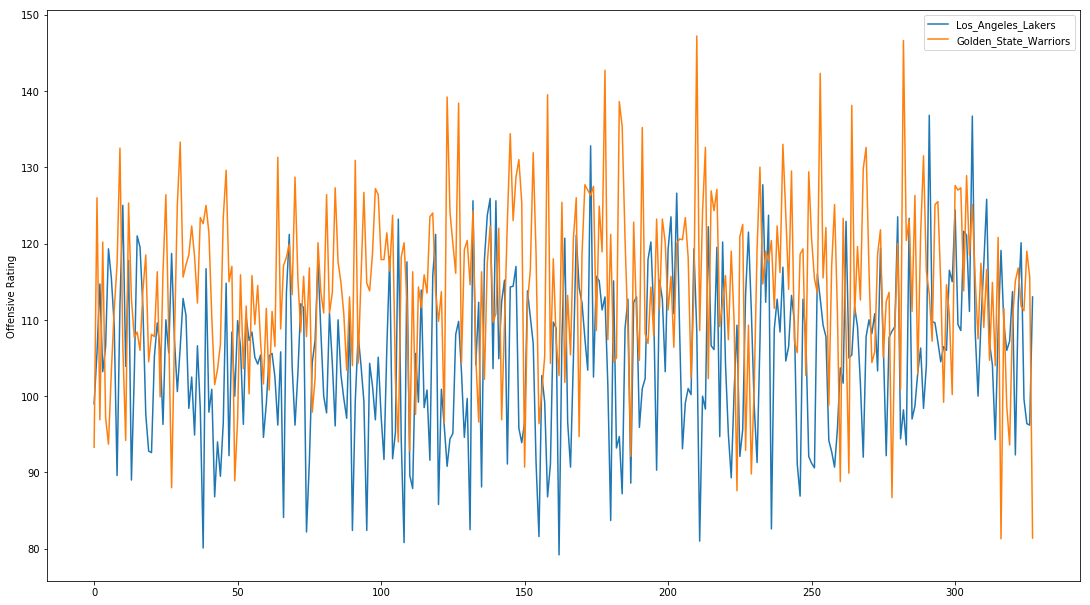

In [47]:
plt.plot(pd.to_numeric(game_results['Los_Angeles_Lakers']['ORtg']))
plt.plot(pd.to_numeric(game_results['Golden_State_Warriors']['ORtg']))
plt.ylabel('Offensive Rating')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend(['Los_Angeles_Lakers','Golden_State_Warriors'])

From plot above we can see Warriors's Offensive Rating is mainly higher than Lakers, and we know the Warriors's team record is much better than Lakers recent years.

### Get all Box game schedules from Season 2015 to Season 2018

In [48]:
schedules = pd.DataFrame()
for year in [2015,2016,2017,2018]:
    for month in ['october', 'november', 'december', 'january', 'february', 'march', 'april', 'may', 'june']:
        url = 'https://www.basketball-reference.com/leagues/NBA_'+ str(year) +'_games-'+ month +'.html'
        html = requests.get(url).content
        df_list = pd.read_html(html)
        df = df_list[0]
        if 'Playoffs' in list(df.Date):
            df.drop(df[df.Date=='Playoffs'].index, inplace=True)
        df.drop(df[df.Date=='Date'].index, inplace=True)
        df.drop(df.columns[[6, 9]], axis=1, inplace=True)
        df['Date'] = df.Date.map(lambda x: ''.join(str(pd.to_datetime(x)).split(' ')[0].split('-')))
        df.rename(columns = {'Unnamed: 7':'OverTime'}, inplace=True)
        df.reset_index(drop=True, inplace=True)
        df['Visitor/Neutral'] = df['Visitor/Neutral'].map(lambda x: '_'.join(x.split(' ')))
        df['Home/Neutral'] = df['Home/Neutral'].map(lambda x: '_'.join(x.split(' ')))
        schedules = schedules.append(df, ignore_index=True, sort=False)

In [50]:
schedules.shape

(5248, 8)

In [49]:
schedules.head(10)

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,OverTime,Attend.
0,20141028,10:30p,Houston_Rockets,108,Los_Angeles_Lakers,90,NaN,18997
1,20141028,8:00p,Orlando_Magic,84,New_Orleans_Pelicans,101,NaN,17097
2,20141028,8:00p,Dallas_Mavericks,100,San_Antonio_Spurs,101,NaN,19615
3,20141029,7:30p,Brooklyn_Nets,105,Boston_Celtics,121,NaN,18624
4,20141029,7:00p,Milwaukee_Bucks,106,Charlotte_Hornets,108,OT,19439
5,20141029,9:00p,Detroit_Pistons,79,Denver_Nuggets,89,NaN,17136
6,20141029,7:00p,Philadelphia_76ers,91,Indiana_Pacers,103,NaN,18165
7,20141029,8:00p,Minnesota_Timberwolves,101,Memphis_Grizzlies,105,NaN,17731
8,20141029,7:30p,Washington_Wizards,95,Miami_Heat,107,NaN,19744
9,20141029,8:00p,Chicago_Bulls,104,New_York_Knicks,80,NaN,19812


### Get mean of 10 recent game results before the game we analyse as the base data to predict the result of this game. 

In [50]:
if use_intermediate_results == False:
    predic_win = pd.DataFrame()
    for i in range(200,5247):
        date = schedules.iloc[i].Date
        visitor = schedules.iloc[i]['Visitor/Neutral']
        home = schedules.iloc[i]['Home/Neutral']
        idx_1 = team_schedules[visitor][team_schedules[visitor]['Date']== str(date)].index
        if idx_1.values:
            idx_v = idx_1[0]
            df = game_results[visitor].iloc[idx_v-10:idx_v].drop('Date', axis=1)
            d = {}
            for col_name in df.columns[1:]:
                v_name = col_name + str('_v')
                d[v_name] = pd.to_numeric(df[col_name]).mean()
            d['wn_v'] = sum(team_schedules[visitor].iloc[idx_v-10:idx_v]['Win_or_Lose'])   
            idx_2 = team_schedules[home][team_schedules[home]['Date']== str(date)].index
        # if idx_2.values:
            idx_v = idx_2[0]
            df = game_results[home].iloc[idx_v-10:idx_v].drop('Date', axis=1)
            for col_name in df.columns[1:]:
                h_name = col_name + str('_h')
                d[h_name] = pd.to_numeric(df[col_name]).mean()
            d['wn_h'] = sum(team_schedules[home].iloc[idx_v-10:idx_v]['Win_or_Lose'])  
            d['home_win_score'] = int(schedules.iloc[i]['PTS.1']) - int(schedules.iloc[i]['PTS'])
            d['home'] = home
            d['visitor'] = visitor
            predic_win = predic_win.append(pd.DataFrame([d]), ignore_index=True, sort=False)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys


In [67]:
if use_intermediate_results == False:
    predic_win.to_pickle('predic_win.pkl')

In [3]:
if use_intermediate_results == True:
    predic_win = pd.read_pickle("./predic_win.pkl")
#     predic_win = pd.read_pickle("./NBA_Prediction/predic_win.pkl")

In [4]:
predic_win.shape

(4720, 67)

In [5]:
predic_win.head(10)

,3P%_h,3P%_v,3PA_h,3PA_v,3PAr_h,3PAr_v,3P_h,3P_v,AST%_h,AST%_v,...,TRB_v,TS%_h,TS%_v,eFG%_h,eFG%_v,home,home_win_score,visitor,wn_h,wn_v
0,0.3364,0.4241,35.5,18.9,0.4560,0.2348,11.8,7.6,59.86,54.55,...,38.5,0.5302,0.5562,0.4877,0.5217,Houston_Rockets,5,New_York_Knicks,7,2
1,0.3075,0.4163,25.5,24.9,0.3156,0.2997,7.8,10.4,55.79,63.01,...,48.0,0.4844,0.5713,0.4514,0.5324,Philadelphia_76ers,-10,Portland_Trail_Blazers,0,9
2,0.3926,0.3582,22.8,26.3,0.2774,0.3087,8.8,9.5,53.75,51.72,...,42.6,0.5692,0.5605,0.5156,0.5145,Toronto_Raptors,4,Phoenix_Suns,9,6
3,0.3452,0.3588,20.1,19.2,0.2671,0.2366,6.9,7.0,63.30,62.12,...,43.0,0.5463,0.5337,0.5063,0.4956,Utah_Jazz,-2,Chicago_Bulls,4,6
4,0.3623,0.3571,27.1,19.7,0.3183,0.2444,9.7,7.2,55.97,61.11,...,42.1,0.5456,0.5364,0.5078,0.5006,Denver_Nuggets,5,Chicago_Bulls,5,6
5,0.3828,0.3833,22.6,25.2,0.3153,0.3081,8.6,9.7,60.45,65.05,...,44.7,0.5717,0.5830,0.5281,0.5456,Miami_Heat,-17,Golden_State_Warriors,5,8
6,0.2681,0.3794,18.1,23.2,0.2189,0.2770,4.8,8.7,58.92,50.73,...,45.8,0.5123,0.5020,0.4707,0.4663,Milwaukee_Bucks,12,Detroit_Pistons,5,3
7,0.3627,0.3411,20.5,15.6,0.2424,0.1953,7.5,5.1,56.51,54.25,...,45.8,0.5560,0.5615,0.5166,0.4982,New_Orleans_Pelicans,-10,Sacramento_Kings,6,6
8,0.3376,0.3363,14.9,24.8,0.1782,0.3067,5.2,8.4,65.98,64.53,...,39.4,0.5304,0.5605,0.4934,0.5168,Washington_Wizards,-4,Atlanta_Hawks,8,6
9,0.3293,0.3903,25.3,21.4,0.3071,0.2598,8.4,8.4,61.82,52.24,...,39.5,0.5524,0.5710,0.5075,0.5188,Atlanta_Hawks,-11,Toronto_Raptors,6,9


In [6]:
nba_df = predic_win.copy()

In [7]:
def trans(score):
    if score > 0:
        return 1
    else: return 0
nba_df['home_win'] = nba_df.home_win_score.map(trans)
nba_df.head(10)

,3P%_h,3P%_v,3PA_h,3PA_v,3PAr_h,3PAr_v,3P_h,3P_v,AST%_h,AST%_v,...,TS%_h,TS%_v,eFG%_h,eFG%_v,home,home_win_score,visitor,wn_h,wn_v,home_win
0,0.3364,0.4241,35.5,18.9,0.4560,0.2348,11.8,7.6,59.86,54.55,...,0.5302,0.5562,0.4877,0.5217,Houston_Rockets,5,New_York_Knicks,7,2,1
1,0.3075,0.4163,25.5,24.9,0.3156,0.2997,7.8,10.4,55.79,63.01,...,0.4844,0.5713,0.4514,0.5324,Philadelphia_76ers,-10,Portland_Trail_Blazers,0,9,0
2,0.3926,0.3582,22.8,26.3,0.2774,0.3087,8.8,9.5,53.75,51.72,...,0.5692,0.5605,0.5156,0.5145,Toronto_Raptors,4,Phoenix_Suns,9,6,1
3,0.3452,0.3588,20.1,19.2,0.2671,0.2366,6.9,7.0,63.30,62.12,...,0.5463,0.5337,0.5063,0.4956,Utah_Jazz,-2,Chicago_Bulls,4,6,0
4,0.3623,0.3571,27.1,19.7,0.3183,0.2444,9.7,7.2,55.97,61.11,...,0.5456,0.5364,0.5078,0.5006,Denver_Nuggets,5,Chicago_Bulls,5,6,1
5,0.3828,0.3833,22.6,25.2,0.3153,0.3081,8.6,9.7,60.45,65.05,...,0.5717,0.5830,0.5281,0.5456,Miami_Heat,-17,Golden_State_Warriors,5,8,0
6,0.2681,0.3794,18.1,23.2,0.2189,0.2770,4.8,8.7,58.92,50.73,...,0.5123,0.5020,0.4707,0.4663,Milwaukee_Bucks,12,Detroit_Pistons,5,3,1
7,0.3627,0.3411,20.5,15.6,0.2424,0.1953,7.5,5.1,56.51,54.25,...,0.5560,0.5615,0.5166,0.4982,New_Orleans_Pelicans,-10,Sacramento_Kings,6,6,0
8,0.3376,0.3363,14.9,24.8,0.1782,0.3067,5.2,8.4,65.98,64.53,...,0.5304,0.5605,0.4934,0.5168,Washington_Wizards,-4,Atlanta_Hawks,8,6,0
9,0.3293,0.3903,25.3,21.4,0.3071,0.2598,8.4,8.4,61.82,52.24,...,0.5524,0.5710,0.5075,0.5188,Atlanta_Hawks,-11,Toronto_Raptors,6,9,0


In [8]:
nba_X = nba_df.drop(['home', 'home_win_score', 'visitor', 'home_win'],axis = 1)
nba_X.shape

(4720, 64)

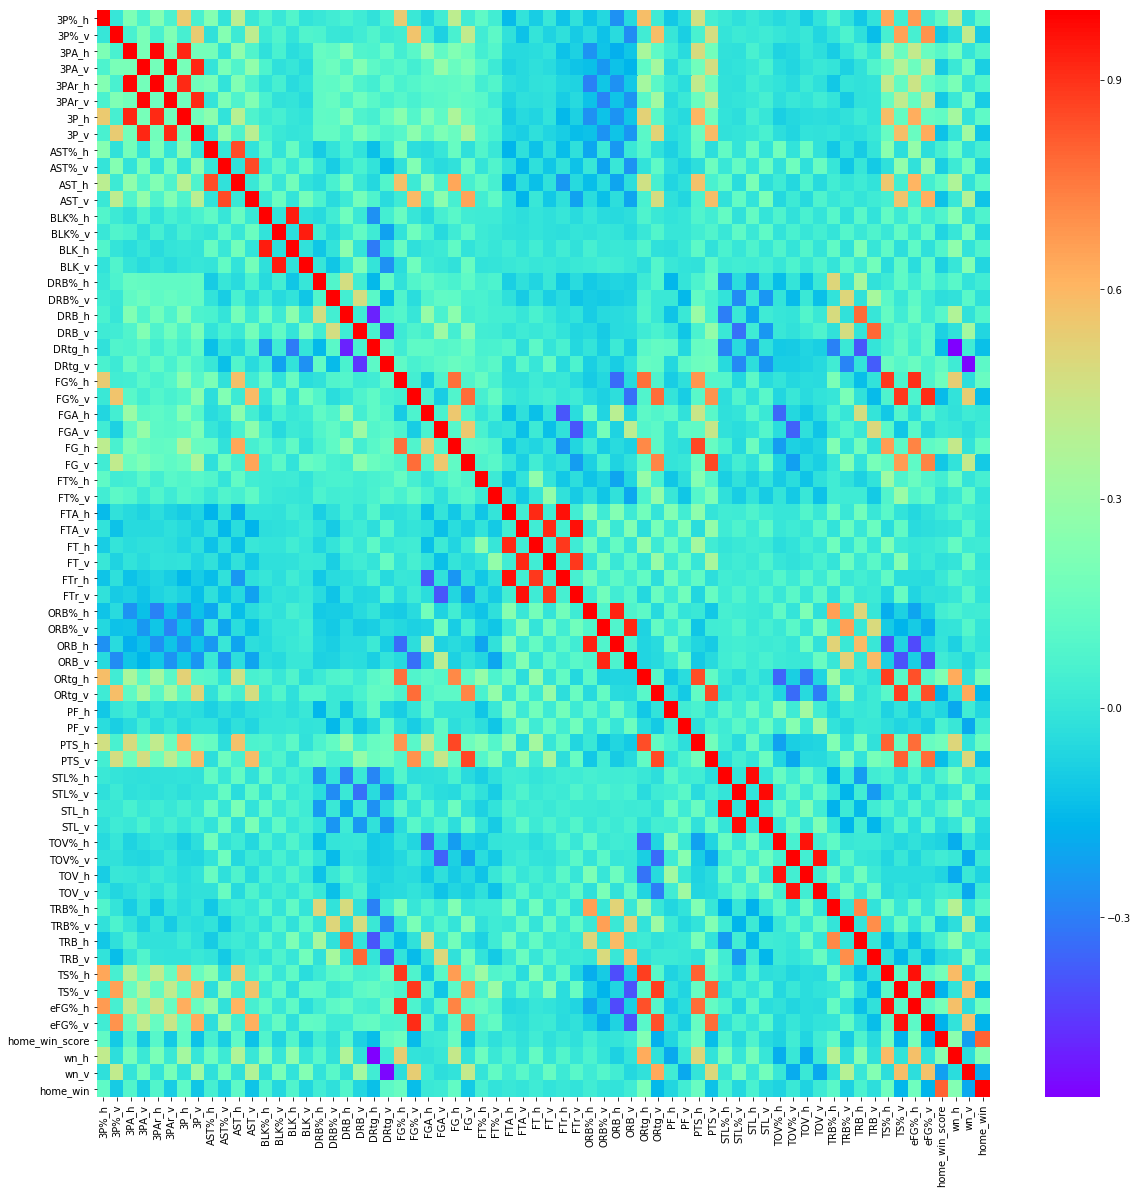

In [9]:
import seaborn as sns
corr = nba_df.corr()
plt.figure(figsize = (20,20))
sns.heatmap(corr, annot=False, cmap=plt.cm.rainbow)
plt.show()

In [10]:
# get corr greater than 0.3 with wn home
selected_feat_home = abs(corr['wn_h'])>0.4
home_feature_df = selected_feat_home[selected_feat_home==True].to_frame()
home_feature_list = list(home_feature_df.index)
len(home_feature_list)

9

In [11]:
# get corr greater than 0.3 with wn vistor
selected_feat_vis = abs(corr['wn_v'])>0.4
vis_feature_df = selected_feat_vis[selected_feat_vis==True].to_frame()
vis_feature_list = list(vis_feature_df.index)
len(vis_feature_list)

9

In [12]:
selected_features = home_feature_list + vis_feature_list
selected_features

['3P%_h',
 'DRtg_h',
 'FG%_h',
 'FG_h',
 'ORtg_h',
 'PTS_h',
 'TS%_h',
 'eFG%_h',
 'wn_h',
 '3P%_v',
 'DRtg_v',
 'FG%_v',
 'FG_v',
 'ORtg_v',
 'PTS_v',
 'TS%_v',
 'eFG%_v',
 'wn_v']

In [76]:
# selected_features.append('PTS_v')

In [13]:
huidu_X = nba_df.loc[:, selected_features]
huidu_X.shape

(4720, 18)

In [14]:
huidu_X.head(10)

,3P%_h,DRtg_h,FG%_h,FG_h,ORtg_h,PTS_h,TS%_h,eFG%_h,wn_h,3P%_v,DRtg_v,FG%_v,FG_v,ORtg_v,PTS_v,TS%_v,eFG%_v,wn_v
0,0.3364,99.49,0.4113,32.0,102.12,94.7,0.5302,0.4877,7,0.4241,112.48,0.4742,38.0,109.41,98.2,0.5562,0.5217,2
1,0.3075,109.28,0.4033,32.6,91.74,88.6,0.4844,0.4514,0,0.4163,100.66,0.4700,39.0,112.84,105.7,0.5713,0.5324,9
2,0.3926,99.78,0.4623,38.0,115.23,107.1,0.5692,0.5156,9,0.3582,104.23,0.4586,38.9,108.48,105.8,0.5605,0.5145,6
3,0.3452,111.95,0.4600,34.8,105.36,93.9,0.5463,0.5063,4,0.3588,105.26,0.4527,36.7,106.11,98.4,0.5337,0.4956,6
4,0.3623,111.67,0.4507,38.5,110.39,105.5,0.5456,0.5078,5,0.3571,105.67,0.4560,36.8,105.84,98.3,0.5364,0.5006,6
5,0.3828,107.37,0.4679,33.8,106.45,93.9,0.5717,0.5281,5,0.3833,99.15,0.4857,39.5,107.31,105.6,0.5830,0.5456,8
6,0.2681,108.17,0.4413,36.7,101.92,95.6,0.5123,0.4707,5,0.3794,106.46,0.4136,34.5,102.49,93.8,0.5020,0.4663,3
7,0.3627,109.41,0.4724,39.9,112.91,104.2,0.5560,0.5166,6,0.3411,109.00,0.4657,37.3,112.59,106.6,0.5615,0.4982,6
8,0.3376,100.10,0.4624,38.5,105.03,99.2,0.5304,0.4934,8,0.3363,108.36,0.4643,37.6,109.12,102.3,0.5605,0.5168,6
9,0.3293,109.06,0.4560,37.7,109.16,102.7,0.5524,0.5075,6,0.3903,100.35,0.4679,38.5,114.87,107.5,0.5710,0.5188,9


In [15]:
y = nba_df['home_win']
y.shape

(4720,)

In [16]:
random_state = 0
X_train, X_val, y_train, y_val =  train_test_split(huidu_X, y, test_size=.2, random_state=random_state)

In [17]:
X_train.head(10)

,3P%_h,DRtg_h,FG%_h,FG_h,ORtg_h,PTS_h,TS%_h,eFG%_h,wn_h,3P%_v,DRtg_v,FG%_v,FG_v,ORtg_v,PTS_v,TS%_v,eFG%_v,wn_v
1465,0.4086,105.34,0.4822,42.2,114.41,115.0,0.5864,0.5540,9,0.3532,98.96,0.4402,36.3,104.98,97.5,0.5326,0.4947,7
1377,0.3382,105.67,0.4413,36.8,104.77,100.9,0.5402,0.4994,4,0.3303,106.01,0.4342,36.8,101.32,98.3,0.5204,0.4818,3
34,0.3290,112.14,0.4697,37.6,112.55,103.1,0.5684,0.5192,7,0.3532,112.46,0.4323,36.4,102.83,93.9,0.5047,0.4699,1
286,0.4278,111.12,0.4386,38.1,107.35,103.1,0.5326,0.4968,4,0.3330,107.98,0.4503,40.0,108.06,104.3,0.5273,0.4858,6
465,0.3808,100.20,0.4288,36.7,105.64,99.1,0.5207,0.4807,7,0.3822,96.91,0.4604,37.1,102.83,94.8,0.5359,0.5022,5
2373,0.2885,106.92,0.4405,40.3,101.88,107.6,0.5194,0.4732,3,0.3659,103.15,0.4396,37.7,105.40,100.2,0.5249,0.4862,6
1752,0.3200,106.34,0.4627,39.5,105.82,105.3,0.5416,0.5004,4,0.3437,108.81,0.4762,39.6,113.34,103.3,0.5589,0.5283,7
2188,0.3803,111.66,0.5103,41.9,113.96,107.6,0.5839,0.5513,6,0.3543,106.66,0.4412,37.9,109.18,103.2,0.5322,0.4952,7
629,0.3283,104.83,0.4298,37.3,105.62,102.9,0.5283,0.4939,6,0.3618,109.70,0.4531,36.6,107.49,99.9,0.5389,0.4840,5
3643,0.3553,114.44,0.4432,37.5,100.52,93.9,0.5124,0.4855,1,0.3468,101.36,0.4519,40.0,107.58,104.4,0.5397,0.5135,4


In [18]:
from sklearn.linear_model import LogisticRegressionCV

In [19]:
clf = LogisticRegressionCV(cv=5, random_state=0, max_iter=1000).fit(X_train, y_train)

In [20]:
score_lr = clf.score(X_val, y_val)

In [21]:
clf_svm = SVC(gamma='auto')
clf_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
score_svm = clf_svm.score(X_val, y_val)

In [24]:
import xgboost as xgb

In [25]:
xgb_reg = xgb.XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, n_jobs=-1, subsample=.7)
xgb_reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

In [26]:
X = predic_win.drop(['home', 'home_win_score', 'visitor'], axis=1)
print(X.shape)
y = predic_win['home_win_score']
print(y.shape)

(4720, 64)
(4720,)


In [27]:
random_state = 0
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=.2, random_state=random_state)

In [28]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

/srv/conda/envs/notebook/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:41:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:13.5809	validation_1-rmse:13.3177
[1]	validation_0-rmse:13.4484	validation_1-rmse:13.23
[2]	validation_0-rmse:13.3262	validation_1-rmse:13.1264
[3]	validation_0-rmse:13.2138	validation_1-rmse:13.0413
[4]	validation_0-rmse:13.1241	validation_1-rmse:12.9857
[5]	validation_0-rmse:13.0488	validation_1-rmse:12.9466
[6]	validation_0-rmse:12.9696	validation_1-rmse:12.8853
[7]	validation_0-rmse:12.8994	validation_1-rmse:12.8418
[8]	validation_0-rmse:12.8368	validation_1-rmse:12.8084
[9]	validation_0-rmse:12.7732	validation_1-rmse:12.7566
[10]	validation_0-rmse:12.7191	validation_1-rmse:12.7238
[11]	validation_0-rmse:12.6705	validation_1-rmse:12.6993
[12]	validation_0-rmse:12.63	validation_1-rmse:12.665
[13]	validation_0-rmse:12.5949	validation_1-rmse:12.6509
[14]	validation_0-rmse:12.5583	validation_1-rmse:12.6311
[15]	validation_0-rmse:12.5214	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1)

In [29]:
results = xgb_reg.evals_result()

In [30]:
n_iter = len(results['validation_0']['rmse'])
n_iter

100

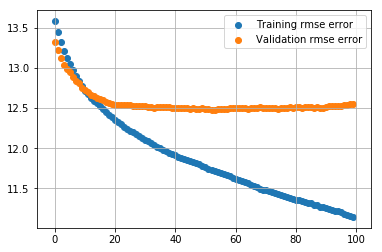

In [31]:
plt.scatter(list(range(n_iter)), results['validation_0']['rmse'], label='Training rmse error')
plt.scatter(list(range(n_iter)), results['validation_1']['rmse'], label='Validation rmse error')
plt.grid(True)
plt.legend()

We can see the performance of this model is not so good, but this is the best model from models we have used. There is no absolute strong team in NBA, every game result is hard to predict.

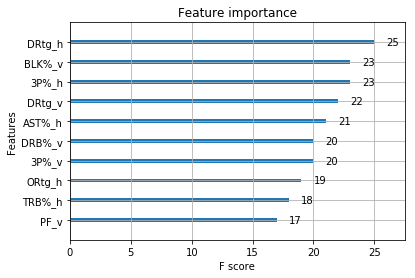

In [32]:
xgb.plot_importance(xgb_reg,max_num_features=10)

From plot above we can see the Defensive, 3-point, Rebound and Assist are keys to win a game.

In [33]:
y_pred = xgb_reg.predict(X_val)

The acuarcy of predict win or lose.

In [34]:
y_p = y_pred>0

In [35]:
y_t = y_val>0

In [37]:
score_xgb = sum(y_p == y_t)/len(y_p)

Text(0.5, 1.0, 'Accuracy among LR , SVM and XGB')

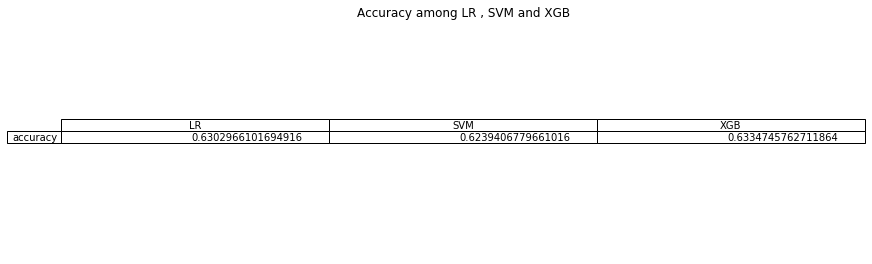

In [43]:
cell_text = [[score_lr, score_svm,score_xgb]]
columns = ('LR', 'SVM', 'XGB')
rows = ["accuracy"]
fig, ax = plt.subplots()
# ax.xaxis.set_visible(False)
ax.axis('off')
ax.table(cellText=cell_text,rowLabels=rows, colLabels=columns, colWidths = [0.8, 0.8, 0.8], loc="center")
ax.set_title("Accuracy among LR , SVM and XGB")

From result we can see if we only predict home or visitor win, the acuarcy is 66%, which is not bad.

# Player Stats

We can also get a play's every game performance

In [92]:
url = 'https://www.basketball-reference.com/players/j/jamesle01/gamelog/2004/'
html = requests.get(url).content
df_list = pd.read_html(html)
lebron_james = df_list[-1]

#### Glossary:
    Rk -- Rank  G -- Season Game  Age -- Age of Player at the start of February 1st of that season.  Tm -- Team
    Opp -- Opponent  GS -- Games Started  MP -- Minutes Played  FG -- Field Goals  FGA -- Field Goal Attempts
    FG% -- Field Goal Percentage  3P -- 3-Point Field Goals  3PA -- 3-Point Field Goal Attempts  
    3P% -- 3-Point Field Goal Percentage  FT -- Free Throws  FTA -- Free Throw Attempts  
    FT% -- Free Throw Percentage  ORB -- Offensive Rebounds  DRB -- Defensive Rebounds  TRB -- Total Rebounds  
    AST -- Assists  STL -- Steals  BLK -- Blocks  TOV -- Turnovers  PF -- Personal Fouls  PTS -- Points  
    GmSc -- Game Score  +/- -- Plus/Minus

In [93]:
lebron_james.head(10)

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1,2003-10-29,18-303,CLE,@,SAC,L (-14),1,42:00,...,4,6,9,4,0,2,3,25,24.7,-9
1,2,2,2003-10-30,18-304,CLE,@,PHO,L (-9),1,41:00,...,10,12,8,1,0,7,1,21,14.7,-3
2,3,3,2003-11-01,18-306,CLE,@,POR,L (-19),1,39:00,...,4,4,6,2,0,2,3,8,5.0,-21
3,4,4,2003-11-05,18-310,CLE,NaN,DEN,L (-4),1,41:00,...,9,11,7,2,3,2,1,7,11.2,-3
4,5,5,2003-11-07,18-312,CLE,@,IND,L (-1),1,44:00,...,5,5,3,0,0,7,2,23,9.0,-7
5,6,6,2003-11-08,18-313,CLE,NaN,WAS,W (+13),1,45:00,...,3,8,9,1,1,2,1,17,15.7,+14
6,7,7,2003-11-10,18-315,CLE,NaN,NYK,W (+14),1,34:00,...,4,5,4,1,1,2,0,17,15.8,+20
7,8,8,2003-11-12,18-317,CLE,@,MIA,L (-5),1,42:00,...,2,3,7,2,1,4,3,18,12.8,-4
8,9,9,2003-11-14,18-319,CLE,@,BOS,L (-9),1,35:00,...,4,5,3,0,0,4,3,10,0.8,-1
9,10,10,2003-11-15,18-320,CLE,NaN,PHI,W (+3),1,47:00,...,5,5,8,1,2,5,2,22,15.6,+8


We can see Lebron's rookie year performance is really good.

### Get player stats from Season 2015 to Season 2019.

In [94]:
to_num_list = ['Rk', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

In [95]:
years = [2019,2018,2017,2016,2015]
player_stats = {}
for year in years:
    url = 'https://www.basketball-reference.com/leagues/NBA_'+str(year)+'_per_game.html'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    df = df_list[0]
    df.drop(df[df.Rk=='Rk'].index, inplace=True)
    df[to_num_list] = df[to_num_list].apply(pd.to_numeric)
    player_stats[year] = df

#### Glossary:
    Rk -- Rank  Pos -- Position  Age -- Age of Player at the start of February 1st of that season.
    Tm -- Team  G -- Games  GS -- Games Started  MP -- Minutes Played Per Game  FG -- Field Goals Per Game
    FGA -- Field Goal Attempts Per Game  FG% -- Field Goal Percentage  3P -- 3-Point Field Goals Per Game
    3PA -- 3-Point Field Goal Attempts Per Game  3P% -- FG% on 3-Pt FGAs.  2P -- 2-Point Field Goals Per Game
    2PA -- 2-Point Field Goal Attempts Per Game  2P% -- FG% on 2-Pt FGAs.  
    eFG% -- Effective Field Goal Percentage  This statistic adjusts for the fact that a 3-point field goal is worth one more point than a 2-point field goal.
    FT -- Free Throws Per Game  FTA -- Free Throw Attempts Per Game  FT% -- Free Throw Percentage
    ORB -- Offensive Rebounds Per Game  DRB -- Defensive Rebounds Per Game  TRB -- Total Rebounds Per Game  
    AST -- Assists Per Game  STL -- Steals Per Game  BLK -- Blocks Per Game  TOV -- Turnovers Per Game
    PF -- Personal Fouls Per Game  PTS -- Points Per Game

In [139]:
player_stats[2019]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Alex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9
5,6,Deng Adel,SF,21,CLE,19,3,10.2,0.6,1.9,...,1.000,0.2,0.8,1.0,0.3,0.1,0.2,0.3,0.7,1.7
6,7,DeVaughn Akoon-Purcell,SG,25,DEN,7,0,3.1,0.4,1.4,...,0.500,0.1,0.4,0.6,0.9,0.3,0.0,0.3,0.6,1.0
7,8,LaMarcus Aldridge,C,33,SAS,81,81,33.2,8.4,16.3,...,0.847,3.1,6.1,9.2,2.4,0.5,1.3,1.8,2.2,21.3
8,9,Rawle Alkins,SG,21,CHI,10,1,12.0,1.3,3.9,...,0.667,1.1,1.5,2.6,1.3,0.1,0.0,0.8,0.7,3.7
9,10,Grayson Allen,SG,23,UTA,38,2,10.9,1.8,4.7,...,0.750,0.1,0.5,0.6,0.7,0.2,0.2,0.9,1.2,5.6


Let's see top 30 Points Per Game leader boards.

In [140]:
player_stats[2019].sort_values(by=['PTS'], inplace=True, ascending=False)

In [141]:
player_stats[2019].head(30)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
277,206,James Harden,PG,29,HOU,78,78,36.8,10.8,24.5,...,0.879,0.8,5.8,6.6,7.5,2.0,0.7,5.0,3.1,36.1
249,183,Paul George,SF,28,OKC,77,77,36.9,9.2,21.0,...,0.839,1.4,6.8,8.2,4.1,2.2,0.4,2.7,2.8,28.0
19,18,Giannis Antetokounmpo,PF,24,MIL,72,72,32.8,10.0,17.3,...,0.729,2.2,10.3,12.5,5.9,1.3,1.5,3.7,3.2,27.7
207,155,Joel Embiid,C,24,PHI,64,64,33.7,9.1,18.7,...,0.804,2.5,11.1,13.6,3.7,0.7,1.9,3.5,3.3,27.5
344,258,LeBron James,SF,34,LAL,55,55,35.2,10.1,19.9,...,0.665,1.0,7.4,8.5,8.3,1.3,0.6,3.6,1.7,27.4
165,124,Stephen Curry,PG,30,GSW,69,69,33.8,9.2,19.4,...,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3
71,61,Devin Booker,SG,22,PHO,64,64,35.0,9.2,19.6,...,0.866,0.6,3.5,4.1,6.8,0.9,0.2,4.1,3.1,26.6
412,301,Kawhi Leonard,SF,27,TOR,60,60,34.0,9.3,18.8,...,0.854,1.3,6.0,7.3,3.3,1.8,0.4,2.0,1.5,26.6
198,150,Kevin Durant,PF,30,GSW,78,78,34.6,9.2,17.7,...,0.885,0.4,5.9,6.4,5.9,0.7,1.1,2.9,2.0,26.0
167,126,Anthony Davis,C,25,NOP,56,56,33.0,9.5,18.3,...,0.794,3.1,8.9,12.0,3.9,1.6,2.4,2.0,2.4,25.9


# MVP Voting

Get NBA normal season most valuable player voting results from Season 2000 to Season 2019.

In [8]:
to_num_list = ['Age', 'First', 'Pts Won', 'Pts Max', 'Share', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48']


In [9]:
years = range(2000,2019)
MVP_voting = {}
for year in years:
    url = 'https://www.basketball-reference.com/awards/awards_'+str(year)+'.html'
    html = requests.get(url).content
    df_list = pd.read_html(html)
    df = df_list[0]
    df.columns = df.columns.droplevel()
    df[to_num_list] = df[to_num_list].apply(pd.to_numeric)
    MVP_voting[year] = df

In [10]:
MVP_votings = pd.DataFrame()
for year in range(2000,2019):
    MVP_votings = MVP_votings.append(MVP_voting[year], ignore_index=True, sort=False)
MVP_votings.fillna(0,inplace=True)

In [11]:
MVP_votings['Rank'] = MVP_votings['Rank'].map(lambda x: int(str(x[:-1])) if str(x).endswith('T') else int(x))

In [12]:
MVP_votings.shape

(275, 20)

#### Glossary:
    Age -- Age of Player at the start of February 1st of that season.  Tm -- Team
    Voting  
    First -- First Place Votes
    Totals
    G -- Games  Per Game  MP -- Minutes Played Per Game  PTS -- Points Per Game  TRB -- Total Rebounds Per Game
    AST -- Assists Per Game  STL -- Steals Per Game  BLK -- Blocks Per Game
    Shooting
    FG% -- Field Goal Percentage  3P% -- 3-Point Field Goal Percentage  FT% -- Free Throw Percentage
    Advanced
    WS -- Win Shares  An estimate of the number of wins contributed by a player.
    WS/48 -- Win Shares Per 48 Minutes  An estimate of the number of wins contributed by a player per 48 minutes (league average is approximately .100)

In [13]:
MVP_votings.head(10)

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,1,Shaquille O'Neal,27,LAL,120.0,1207.0,1210,0.998,79,40.0,29.7,13.6,3.8,0.5,3.0,0.574,0.000,0.524,18.6,0.283
1,2,Kevin Garnett,23,MIN,0.0,408.0,1210,0.337,81,40.0,22.9,11.8,5.0,1.5,1.6,0.497,0.370,0.765,11.6,0.172
2,3,Alonzo Mourning,29,MIA,0.0,367.0,1210,0.303,79,34.8,21.7,9.5,1.6,0.5,3.7,0.551,0.000,0.711,12.9,0.226
3,4,Karl Malone,36,UTA,0.0,312.0,1210,0.258,82,35.9,25.5,9.5,3.7,1.0,0.9,0.509,0.250,0.797,15.3,0.249
4,5,Tim Duncan,23,SAS,0.0,248.0,1210,0.205,74,38.9,23.2,12.4,3.2,0.9,2.2,0.490,0.091,0.761,13.0,0.218
5,6,Gary Payton,31,SEA,0.0,180.0,1210,0.149,82,41.8,24.2,6.5,8.9,1.9,0.2,0.448,0.340,0.735,13.9,0.195
6,7,Allen Iverson,24,PHI,1.0,132.0,1210,0.109,70,40.8,28.4,3.8,4.7,2.1,0.1,0.421,0.341,0.713,6.9,0.116
7,8,Grant Hill,27,DET,0.0,113.0,1210,0.093,74,37.5,25.8,6.6,5.2,1.4,0.6,0.489,0.347,0.795,10.7,0.185
8,9,Chris Webber,26,SAC,0.0,96.0,1210,0.079,75,38.4,24.5,10.5,4.6,1.6,1.7,0.483,0.284,0.751,10.7,0.179
9,10,Vince Carter,23,TOR,0.0,51.0,1210,0.042,82,38.1,25.7,5.8,3.9,1.3,1.1,0.465,0.403,0.791,11.8,0.182


Plot hist of every years' MVP.

In [15]:
MVP = MVP_votings[MVP_votings['Rank']==1]

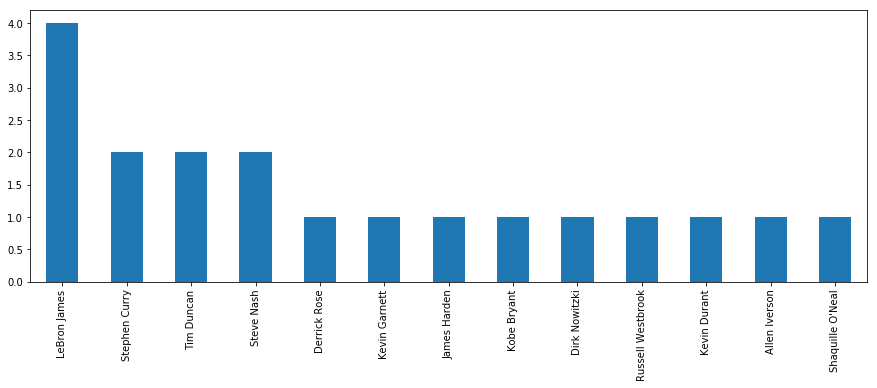

In [26]:
MVP.Player.value_counts().plot.bar(figsize=(15.0,5.0))

From plot above, we can see Lebron James got 4 times normal MVP recent 19 years.

We drop columns which records the journalists voting results, and use other columns which records players' performance to predict their ranking.

In [49]:
X = MVP_votings.drop(labels=['Player','Rank', 'Tm', 'First', 'Pts Won', 'Pts Max', 'Share'], axis= 1)
y = MVP_votings['Rank']

In [88]:
X.columns.tolist()

['Age',
 'G',
 'MP',
 'PTS',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'FG%',
 '3P%',
 'FT%',
 'WS',
 'WS/48']

In [50]:
random_state = 2
train_X, test_X, train_y, test_y =  train_test_split(X, y, test_size=.2, random_state=random_state)

In [51]:
gamma = np.linspace(1e-2,1e-4, 2)
C= np.linspace(1, 1000, 2)
hyper_parameters = [{'kernel': ['rbf'], 'gamma': gamma,
                     'C': C},
                    {'kernel': ['linear'], 'C': C}]

In [61]:
clf = GridSearchCV(SVC(), hyper_parameters, scoring='accuracy',cv=5,n_jobs=-1)

In [62]:
clf.fit(train_X,train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'gamma': array([0.01  , 0.0001]), 'C': array([   1., 1000.])}, {'kernel': ['linear'], 'C': array([   1., 1000.])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [63]:
clf.score(test_X,test_y)

0.14545454545454545

The mean accuracy is 0.145, not good.

In [69]:
x_pred = MVP_voting[2008].drop(labels=['Player','Rank', 'Tm', 'First', 'Pts Won', 'Pts Max','Share'], axis= 1)

In [70]:
clf.predict(x_pred)

array([ 1,  1,  3,  1,  4,  6,  7, 15,  9, 10,  4,  9,  9, 14, 14, 14, 14])

In [71]:
MVP_voting[2008]

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,1,Kobe Bryant,29,LAL,82.0,1100.0,1260,0.873,82,38.9,28.3,6.3,5.4,1.8,0.5,0.459,0.361,0.840,13.8,0.208
1,2,Chris Paul,22,NOH,28.0,894.0,1260,0.710,80,37.6,21.1,4.0,11.6,2.7,0.1,0.488,0.369,0.851,17.8,0.284
2,3,Kevin Garnett,31,BOS,15.0,670.0,1260,0.532,71,32.8,18.8,9.2,3.4,1.4,1.3,0.539,0.000,0.801,12.9,0.265
3,4,LeBron James,23,CLE,1.0,438.0,1260,0.348,75,40.4,30.0,7.9,7.2,1.8,1.1,0.484,0.315,0.712,15.2,0.242
4,5,Dwight Howard,22,ORL,0.0,60.0,1260,0.048,82,37.7,20.7,14.2,1.3,0.9,2.1,0.599,0.000,0.590,12.9,0.200
5,6,Amar'e Stoudemire,25,PHO,0.0,27.0,1260,0.021,79,33.9,25.2,9.1,1.5,0.8,2.1,0.590,0.161,0.805,14.6,0.262
6,7,Tim Duncan,31,SAS,0.0,25.0,1260,0.020,78,34.0,19.3,11.3,2.8,0.7,1.9,0.497,0.000,0.730,11.1,0.201
7,8,Tracy McGrady,28,HOU,0.0,19.0,1260,0.015,66,37.0,21.6,5.1,5.9,1.0,0.5,0.419,0.292,0.684,5.8,0.115
8,9,Steve Nash,33,PHO,0.0,18.0,1260,0.014,81,34.3,16.9,3.5,11.1,0.7,0.1,0.504,0.470,0.906,10.5,0.181
9,10,Manu Ginobili,30,SAS,0.0,9.0,1260,0.007,74,31.1,19.5,4.8,4.5,1.5,0.4,0.460,0.401,0.860,11.1,0.232


Let's predict who will win Season 2019 normal MVP.

First, get all information we need to predict.

In [93]:
url = 'https://www.basketball-reference.com/friv/mvp.html'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[0]

drop_list = []
for i in df.columns.tolist():
    if i not in MVP_voting[2009].columns.tolist():
        drop_list.append(i)

df.drop(labels=drop_list, axis = 1, inplace=True)
df['Age'] = [24, 29, 24, 27, 30, 25, 28, 31, 29, 30]
df['WS'] = [14.4, 15.2, 11.8, 9.5, 11.5, 8.7, 12.1, 9.7, 11.9, 6.8]
df['WS/48'] = [0.292, 0.254, 0.226, 0.224, 0.204, 0.194, 0.205, 0.199, 0.201, 0.124]

Resort cloumns like the training format.

In [95]:
MVP_voting[2019] = df[['Player', 'Tm', 'Age', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48']]

Using model we generated to predict the ranking.

In [98]:
predict_2019 = MVP_voting[2019].drop(labels=['Player', 'Tm'], axis= 1)

In [99]:
clf.predict(predict_2019)

array([ 3,  1,  9, 10,  9,  4,  5,  9,  4,  2])

In [100]:
MVP_voting[2019]

,Player,Tm,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,Giannis Antetokounmpo,MIL,24,72,32.8,27.7,12.5,5.9,1.3,1.5,0.578,0.256,0.729,14.4,0.292
1,James Harden,HOU,29,78,36.8,36.1,6.6,7.5,2.0,0.7,0.442,0.368,0.879,15.2,0.254
2,Nikola Jokic,DEN,24,80,31.3,20.1,10.8,7.3,1.4,0.7,0.511,0.307,0.821,11.8,0.226
3,Kawhi Leonard,TOR,27,60,34.0,26.6,7.3,3.3,1.8,0.4,0.496,0.371,0.854,9.5,0.224
4,Kevin Durant,GSW,30,78,34.6,26.0,6.4,5.9,0.7,1.1,0.521,0.353,0.885,11.5,0.204
5,Joel Embiid,PHI,25,64,33.7,27.5,13.6,3.7,0.7,1.9,0.484,0.300,0.804,8.7,0.194
6,Damian Lillard,POR,28,80,35.5,25.8,4.6,6.9,1.1,0.4,0.444,0.369,0.912,12.1,0.205
7,Stephen Curry,GSW,31,69,33.8,27.3,5.3,5.2,1.3,0.4,0.472,0.437,0.916,9.7,0.199
8,Paul George,OKC,29,77,36.9,28.0,8.2,4.1,2.2,0.4,0.438,0.386,0.839,11.9,0.201
9,Russell Westbrook,OKC,30,73,36.0,22.9,11.1,10.7,1.9,0.5,0.428,0.290,0.656,6.8,0.124


From the predict result we can see, James Harden may win this year's normal MVP.